# Simple Error Model for Twinkles

This notebook will calculate a simple error model for the Twinkles data as a function of the seeing and depth.

### Requirements

You will need the DESC `Monitor` and its dependencies.

You will also need the truth database for the desired Twinkles run.

In [1]:
import os
import desc.monitor
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/Bryce/Documents/lsstRepos/branch/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:439: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/Documents/lsstRepos/branch/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:439: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/Documents/lsstRepos/branch/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:439: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


### Get differences between true and observed fluxes

We first want to get all the differences for the run between the true and observed fluxes and store them in a Pandas Dataframe.

In [2]:
star_db_name = 'twinkles_run1.1.db'

In [3]:
truth_dbConn = desc.monitor.truthDBInterface(database=star_db_name, driver='sqlite')
dbConn_twinkles = desc.monitor.dbInterface(database='DESC_Twinkles_Level_2',
                                           host='127.0.0.1', port='3307',
                                           driver='mysql')

In [4]:
worker = desc.monitor.Monitor(dbConn_twinkles, truth_dbConn=truth_dbConn)

In [5]:
depth_curve = worker.measure_depth_curve()

In [6]:
seeing_curve = worker.measure_seeing_curve()

In [13]:
worker.calc_flux_residuals(with_depth_curve=depth_curve, with_seeing_curve=seeing_curve, for_visits=depth_curve.lightcurve['obsHistId'][:150])

Calculated Residuals for 0 visits out of 150
Calculated Residuals for 10 visits out of 150
Calculated Residuals for 20 visits out of 150
Calculated Residuals for 30 visits out of 150
Calculated Residuals for 40 visits out of 150
Calculated Residuals for 50 visits out of 150
Calculated Residuals for 60 visits out of 150
Calculated Residuals for 70 visits out of 150
Calculated Residuals for 80 visits out of 150
Calculated Residuals for 90 visits out of 150
Calculated Residuals for 100 visits out of 150
Calculated Residuals for 110 visits out of 150
Calculated Residuals for 120 visits out of 150
Calculated Residuals for 130 visits out of 150
Calculated Residuals for 140 visits out of 150


### Plotting Bias and Sigma

Now that we have the data we need in the form of mean flux residuals and mean squared flux residuals for each visit we can combine this with our depth and seeing information to construct plots that show the bias and sigma as functions of these values.

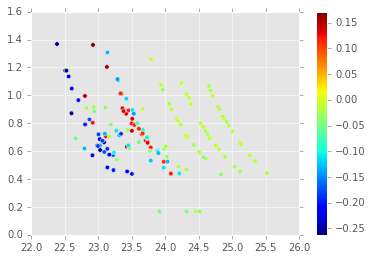

In [14]:
plt.scatter(worker.flux_stats['depth'], worker.flux_stats['seeing'], c=worker.flux_stats['mean_resid'])
plt.colorbar()

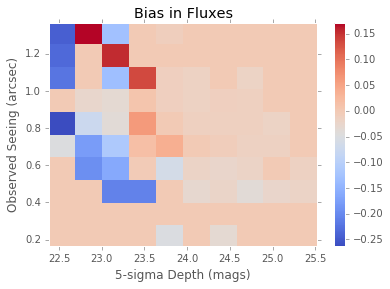

In [34]:
fig = worker.plot_bias(with_bins=10)

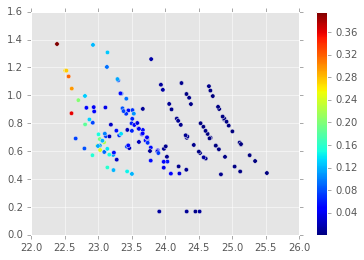

In [17]:
plt.scatter(worker.flux_stats['depth'], worker.flux_stats['seeing'], c=(worker.flux_stats['mean_sq_resid'] - 
                                                                        (worker.flux_stats['mean_resid'])**2))
plt.colorbar()

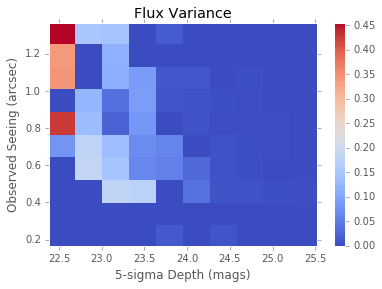

In [36]:
fig = worker.plot_sigma(with_bins=10)